In [2]:
%matplotlib inline

from matplotlib import image
from matplotlib import pyplot as plt
import numpy as np
from numpy import matlib
import cv2
from skimage import io, morphology, color
from skimage.util import view_as_windows as viewW
import sys
from scipy import ndimage
from random import randint, gauss
import random
import math

Let SampleImage contain the image we are sampling from and let Image be the mostly empty image that we want to fill in (if synthesizing from scratch, it should contain a 3-by-3 seed in the center randomly taken from SampleImage, for constrained synthesis it should contain all the known pixels). WindowSize, the size of the neighborhood window, is the only user-settable parameter. The main portion of the algorithm is presented below:

In [3]:
# Pre-processing
apples = image.imread('../images/apples.png')

# settings are given in the pseudocode
SampleImage = color.rgba2rgb(apples)
ErrThreshold = 0.1
MaxErrThreshold = 0.3
WindowSize = 15
Sigma = WindowSize/6.4
seed = 3

In [4]:
# Create a padded image to synthesize
def CreateImage(SampleImage, WindowSize, outputSize):
    new_row, new_col = outputSize[0], outputSize[1]
    # create 3 by 3 seed patch
    row, col = SampleImage.shape[0], SampleImage.shape[1]
    rand_row = randint(0, row - seed)
    rand_col = randint(0, col - seed)
    # create an empty output and filled checker (maybe no need in my code)
    Image = np.zeros((row+new_row, row+new_col, 3))
    Image[0:row, 0:col, :] = SampleImage[:,:,:]
    filledChecker = np.zeros((row+new_row, row+new_col), dtype=np.int8)
    
    # add our current image to the empty output
    center_seed = math.floor(seed / 2)
    center_row_up = math.floor(new_row/2) - center_seed
    center_row_down = math.floor(new_row/2) + center_seed + 1
    center_col_left = math.floor(new_col/2) - center_seed
    center_col_right = math.floor(new_col/2) + center_seed + 1
    
    filledChecker[0:row, 0:col] = 1

    return Image, filledChecker

In [5]:
Image, filledChecker = CreateImage(SampleImage, seed, (100,100))

<Figure size 432x288 with 0 Axes>

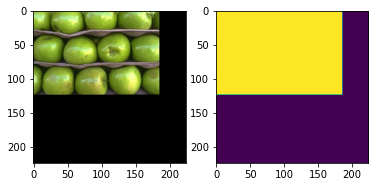

In [8]:
plt.figure()
fig, arr = plt.subplots(1,2) 

arr[0].imshow(Image)
arr[1].imshow(filledChecker)

In [251]:
def GrowImage(SampleImage, Image, filledChecker, WindowSize):
    MaxErrThreshold = 0.3
    center_win = WindowSize-1//2
    total = Image.shape[0] * Image.shape[1]
    Filled = SampleImage.shape[0] * SampleImage.shape[1]

    while (Filled < total):
        progress = 0
        pixel_list = GetUnfilledNeighbors(filledChecker, WindowSize)
        # let it fix the value in the image
        for pixel in pixel_list:
            pixel_row = pixel[0]
            pixel_col = pixel[1]
            [template, validMask] = GetNeighborhoodWindow(Image, filledChecker, WindowSize, pixel_row, pixel_col)
            [best_matches, SSD] = FindMatches(Sigma, template, validMask, ErrThreshold, SampleImage, WindowSize)
            [bestMatch, bestMatchVal, bestMatch_err] = RandomPick(best_matches, SSD, WindowSize, SampleImage)
            if(bestMatch_err < MaxErrThreshold):
                Image[pixel_row,pixel_col,:] = bestMatchVal
                filledChecker[pixel_row, pixel_col] = 1
                Filled += 1
                progress = 1
        if progress == 1:
            MaxErrThreshold *= 1.1
    return Image

In [184]:
def GetNeighborhoodWindow(Image, filledChecker, WindowSize, pixel_row, pixel_col):
    center_win = math.floor((WindowSize - 1)/ 2)
    outputRow, outputCol = Image.shape[0], Image.shape[1]
    rLow, rHigh = pixel_row - center_win, pixel_row + center_win +1
    cLow, cHigh = pixel_col - center_win, pixel_col + center_win+1
    
    rowRange = np.arange(rLow, rHigh)
    colRange = np.arange(cLow, cHigh)
    
    row_invHigh = rowRange > outputRow
    row_invLow = rowRange < 0

    col_invHigh = colRange > outputRow
    col_invLow = colRange < 0
    
    badRow = row_invHigh.any() or row_invLow.any()
    badCol = col_invHigh.any() or col_invLow.any() 
    
    if (badRow.any() == 1 or badCol.any() == 1):
        goodRow = rowRange[~badRow]
        goodCol = colRange[~badCol]
        template = np.zeros([WindowSize, WindowSize, 3])
        template[goodRow, goodCol, :] = Image[goodRow, goodCol, :]
        validMask = np.zeros([WindowSize, WindowSize])
        validMask[~badRow, ~badCol] = filledChecker[goodRow, goodCol]
    else:
        if colRange[2] > filledChecker.shape[1]:
            colRange[2] -=1
        template = Image[rLow:rHigh, cLow:cHigh, :]
        validMask = filledChecker[rLow:rHigh, cLow:cHigh]
    return template, validMask

In [166]:
# B = colfilt(A,[m n],block_type,fun) processes the image A by rearranging each m-by-n block of A 
# into a column of a temporary matrix, and then applying the function fun to this matrix. 
# colfilt zero-pads A, if necessary.

def colfilt(M, win_size):
    rows, cols = M.shape
    new_M = np.zeros((rows, cols))
    pad = win_size // 2
    for i in range(pad, rows):
        for j in range(pad, cols):
            new_M[i,j] = sum(sum(M[i-pad : i+pad+1, j-pad : j+pad+1]))
    return new_M

In [283]:
def GetUnfilledNeighbors(checker, win_size):
    dilated_img = morphology.dilation(checker, np.ones((3,3)))
    unfilledPixels = dilated_img - checker    
    [pixel_rows, pixel_cols] = np.where(unfilledPixels > 0)
    rand_index = np.random.permutation(len(pixel_rows))
    pixel_rows = pixel_rows[rand_index]
    pixel_cols = pixel_cols[rand_index]

    neigh_sums = colfilt(checker, win_size)
    permuted = neigh_sums[pixel_rows, pixel_cols]
    sorted_permuted = np.argsort(permuted)[::-1]
    pixel_list = pixel_rows[rand_index][sorted_permuted], pixel_cols[rand_index][sorted_permuted]
    return pixel_list

In [284]:
def RandomPick(bestMatches, SSD, WindowSize, SampleImage):
    bestMatch = bestMatches[math.ceil(random.random()*len(bestMatches))]
    bestMatchErr = SSD[:, bestMatch]
    [rowMatch, colMatch] = ind2sub(abs(np.array([SampleImage.shape[0],SampleImage.shape[1],SampleImage.shape[2]])
                                       - np.array([WindowSize, WindowSize, WindowSize]) + 1), bestMatch);
    mid = math.floor((WindowSize - 1) / 2);

    bestMatchVal = SampleImage[round(rowMatch + mid), round(colMatch + mid)]
    return bestMatch, bestMatchVal, bestMatchErr

In [292]:
Image = GrowImage(SampleImage, Image, filledChecker, WindowSize)

(array([0]), array([3717]))
<class 'tuple'>


TypeError: type numpy.ndarray doesn't define __round__ method

Function GetUnfilledNeighbors() returns a list of all unfilled pixels that have filled pixels as their neighbors (the image is subtracted from its morphological dilation). The list is randomly permuted and then sorted by decreasing number of filled neighbor pixels. GetNeigborhoodWindow() returns a window of size WindowSize around a given pixel. RandomPick() picks an element randomly from the list. FindMatches() is as follows:


In [291]:
def FindMatches(Sigma, template, validMask, ErrThreshold, SampleImage, WindowSize):
    center_win = (WindowSize - 1) // 2 
    GaussMask = Gaussian2D(WindowSize, Sigma)
    mask = np.multiply(GaussMask, validMask)
    TotWeight = np.sum(mask)

    red_col = im2col(SampleImage[:,:,0], (WindowSize, WindowSize))
    green_col = im2col(SampleImage[:,:,1], (WindowSize, WindowSize))
    blue_col = im2col(SampleImage[:,:,2], (WindowSize, WindowSize))
    
    [pixelsInNeighborhood, numNeighborhoods] = red_col.shape
    
    red_val = template[:,:,0]
    green_val = template[:,:,1]
    blue_val = template[:,:,2]
    
    red_val = matlib.repmat(red_val.reshape(-1, 1), 1, numNeighborhoods)
    green_val = matlib.repmat(green_val.reshape(-1, 1), 1, numNeighborhoods)
    blue_val = matlib.repmat(blue_val.reshape(-1, 1), 1, numNeighborhoods)

    
    red_dist =  np.dot(mask.reshape(-1, 1).T, np.power((red_val - red_col), 2))
    green_dist = np.dot(mask.reshape(-1, 1).T, np.power((green_val - green_col), 2))
    blue_dist = np.dot(mask.reshape(-1, 1).T, np.power((blue_val - blue_col), 2))
    SSD = (red_dist + green_dist + blue_dist) / TotWeight;
    PixelList = np.where(np.multiply((SSD <= np.min(SSD)), (1+ErrThreshold)))
    return PixelList, SSD

In [14]:
def ind2sub(array_shape, ind):
    rows = (ind.astype('int') / array_shape[1])
    cols = (ind.astype('int') % array_shape[1])
    return (rows, cols)

def im2col(image, block_size, skip=1):
    rows, cols = image.shape
    horz_blocks = cols - block_size[1] + 1
    vert_blocks = rows - block_size[0] + 1
    
    if vert_blocks <= 0 or horz_blocks <= 0:
        return np.zeros((block_size[0] * block_size[1], 0), dtype = image.dtype)

    output_vectors = np.zeros((block_size[0] * block_size[1], horz_blocks * vert_blocks), dtype = image.dtype)
    itr = 0
    
    for v_b in range(vert_blocks):
        for h_b in range(horz_blocks):
            output_vectors[:, itr] = image[v_b: v_b + block_size[0], h_b: h_b + block_size[1]].ravel()
            itr += 1

    return output_vectors[:, ::skip]


Gaussian2D() generates a two-dimensional Gaussian in a window of given a size centered in the center and with a given standard deviation (in pixels). In our implementation the constant were set as follows: ErrThreshold = 0.1, MaxErrThreshold = 0.3, Sigma = WindowSize/6.4. Pixel values are in the range of 0 to 1. 

In [16]:
def Gaussian2D(WindowSize, Sigma):
    center = WindowSize//2
    kernel = np.zeros((WindowSize, WindowSize))
    for i in range(WindowSize):
        for j in range(WindowSize):
            diff = np.sqrt((i-center)**2 + (j-center)**2)
            kernel[i,j] = np.exp(-(diff**2)/(2*Sigma**2))
    return kernel/np.sum(kernel)

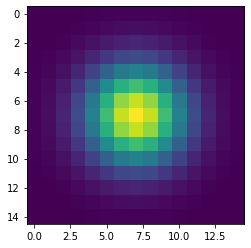

In [17]:
plt.imshow(Gaussian2D(WindowSize, Sigma))